# SIPPY 
A tool to process the job results from https://testgrid.k8s.io/

Sippy provides dashboards  for the openshift CI test/job data.
It contains the health summary for CI’s latest release.
Reports on which tests fail most frequently along different dimensions:
* overall
* by job
* by platform (e.g. aws, gcp, etc)
* by sig (sig ownership of the test)
* Job runs that had large groups of test failures in a single run (generally indicative of a fundamental issue rather than a test problem)
* Job pass rates (which jobs are failing frequently, which are not, in sorted order)

In this notebook we will be looking at the existing testgrid data at testgrid.k8s.io, giving specific attention to [Red Hat's CI dashboards](https://testgrid.k8s.io/redhat-openshift-informing).


###  Getting the data :

In [1]:
import requests
import os
import sys
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# adding path to notebook consisting of modules to be imported
module_path = os.path.abspath(os.path.join("../../TestGrid"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from ipynb.fs.defs.testgrid_EDA import decode_run_length  # noqa: E402

### List all the available dashboards

We need a programmatic way to access all the available Red Hat Dashboards on testgrid. This can be done by scrapping the html of any one of the dashboards. 

In [4]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-informing?id=dashboard-group-bar"
)

In [5]:
html = BeautifulSoup(response.content)
testgrid_script = html.findAll("script")[3]
testgrid_script = testgrid_script.text.split()[5].split(",")
dashboard_names = [x.split(":")[1] for x in testgrid_script if "name" in x]
dashboard_names

['"redhat-assisted-installer"',
 '"redhat-openshift-informing"',
 '"redhat-openshift-ocp-release-3.11-informing"',
 '"redhat-openshift-ocp-release-4.1-blocking"',
 '"redhat-openshift-ocp-release-4.1-informing"',
 '"redhat-openshift-ocp-release-4.10-blocking"',
 '"redhat-openshift-ocp-release-4.10-broken"',
 '"redhat-openshift-ocp-release-4.10-informing"',
 '"redhat-openshift-ocp-release-4.2-blocking"',
 '"redhat-openshift-ocp-release-4.2-informing"',
 '"redhat-openshift-ocp-release-4.3-blocking"',
 '"redhat-openshift-ocp-release-4.3-informing"',
 '"redhat-openshift-ocp-release-4.4-blocking"',
 '"redhat-openshift-ocp-release-4.4-broken"',
 '"redhat-openshift-ocp-release-4.4-informing"',
 '"redhat-openshift-ocp-release-4.5-blocking"',
 '"redhat-openshift-ocp-release-4.5-broken"',
 '"redhat-openshift-ocp-release-4.5-informing"',
 '"redhat-openshift-ocp-release-4.6-blocking"',
 '"redhat-openshift-ocp-release-4.6-informing"',
 '"redhat-openshift-ocp-release-4.7-blocking"',
 '"redhat-openshi

### Inspect at a specific release summary dashboard

Now that we have a programmatic way of collecting all the dashboard names we can use this later on to collect all the available data provided by testgrid. Let's take a look at a specific dashboard and see what kind of info its summary holds. 

In [6]:
dashboard = "redhat-openshift-ocp-release-4.6-informing"

In [7]:
response = requests.get(f"https://testgrid.k8s.io/{dashboard}/summary")

In [8]:
data = response.json()

In [9]:
ocp46 = pd.DataFrame(data)
ocp46.columns

Index(['canary-release-openshift-origin-installer-e2e-aws-4.6-cnv',
       'periodic-ci-openshift-multiarch-master-nightly-4.6-ocp-e2e-remote-libvirt-ppc64le',
       'periodic-ci-openshift-multiarch-master-nightly-4.6-ocp-e2e-remote-libvirt-s390x',
       'periodic-ci-openshift-multiarch-master-nightly-4.6-ocp-image-ecosystem-remote-libvirt-ppc64le',
       'periodic-ci-openshift-multiarch-master-nightly-4.6-ocp-image-ecosystem-remote-libvirt-s390x',
       'periodic-ci-openshift-multiarch-master-nightly-4.6-ocp-installer-remote-libvirt-ppc64le',
       'periodic-ci-openshift-multiarch-master-nightly-4.6-ocp-jenkins-e2e-remote-libvirt-ppc64le',
       'periodic-ci-openshift-multiarch-master-nightly-4.6-ocp-jenkins-e2e-remote-libvirt-s390x',
       'periodic-ci-openshift-release-master-ci-4.6-e2e-aws',
       'periodic-ci-openshift-release-master-ci-4.6-e2e-aws-calico',
       'periodic-ci-openshift-release-master-ci-4.6-e2e-aws-network-stress',
       'periodic-ci-openshift-release-ma

For each dashboard there are a number of jobs associated with it (We will use these column names later to get the access the detailed data). And for each job we have a number of features, some which contain additional data. 

* last run
* last update
* latest_green
* overall_status
* overall_status_icon
* status**
* tests**
* dashboard_name
* healthiness**

_** features that have additional data_

In [10]:
print(ocp46.columns[0])
ocp46.loc["tests", ocp46.columns[0]]

canary-release-openshift-origin-installer-e2e-aws-4.6-cnv


[{'display_name': 'Overall',
  'test_name': 'Overall',
  'fail_count': 27,
  'fail_timestamp': 1628796570,
  'pass_timestamp': 0,
  'build_link': '',
  'build_url_text': '',
  'build_link_text': '',
  'failure_message': '',
  'linked_bugs': [],
  'fail_test_link': ' Overall'},
 {'display_name': 'canary-release-openshift-origin-installer-e2e-aws-4.6-cnv.Overall',
  'test_name': 'canary-release-openshift-origin-installer-e2e-aws-4.6-cnv.Overall',
  'fail_count': 3,
  'fail_timestamp': 1633463026,
  'pass_timestamp': 0,
  'build_link': '',
  'build_url_text': '',
  'build_link_text': '',
  'failure_message': '',
  'linked_bugs': [],
  'fail_test_link': ' canary-release-openshift-origin-installer-e2e-aws-4.6-cnv.Overall'},
 {'display_name': 'operator.Run template e2e-aws',
  'test_name': 'operator.Run template e2e-aws',
  'fail_count': 10,
  'fail_timestamp': 1632253244,
  'pass_timestamp': 0,
  'build_link': '',
  'build_url_text': '',
  'build_link_text': '',
  'failure_message': 'templa

For a detailed analysis, we will be looking into the data for a particular job from the (shown in the list above) 
* dashboard : `redhat-openshift-ocp-release-4.6-informing`  
* job : `https://testgrid.k8s.io/redhat-openshift-ocp-release-4.2-informing/table?&show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-shared-vpc-4.6`   


In [11]:
response = requests.get(
    "https://testgrid.k8s.io/redhat-openshift-ocp-release-4.6-informing/table? \
&show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-shared-vpc-4.6"
)  # noqa

In [12]:
for i in response.json().keys():
    print(i)

test-group-name
query
status
phase-timer
cached
summary
bugs
changelists
column_ids
custom-columns
column-header-names
groups
metrics
tests
row_ids
timestamps
clusters
test_id_map
idMap
test-metadata
stale-test-threshold
num-stale-tests
add-tabular-names-option
show-tabular-names
description
bug-component
code-search-path
open-test-template
file-bug-template
attach-bug-template
results-url-template
code-search-url-template
about-dashboard-url
open-bug-template
context-menu-template
column-diff-link-templates
results-text
latest-green
triage-enabled
notifications
overall-status


In [13]:
details = pd.DataFrame(response.json()["tests"])
details.columns

Index(['name', 'original-name', 'alert', 'linked_bugs', 'messages',
       'short_texts', 'statuses', 'target', 'user_property'],
      dtype='object')

In [14]:
details.head()

,name,original-name,alert,linked_bugs,messages,short_texts,statuses,target,user_property
0,openshift-tests.[sig-imageregistry][Feature:Im...,openshift-tests.[sig-imageregistry][Feature:Im...,None,[],[0/2 runs passed: fail [k8s.io/kubernetes@v1.1...,"[0/2, , , , , 1/2, , , , , , , , , , , , , , ,...","[{'count': 1, 'value': 12}, {'count': 4, 'valu...",openshift-tests.[sig-imageregistry][Feature:Im...,None
1,openshift-tests.[sig-imageregistry][Feature:Im...,openshift-tests.[sig-imageregistry][Feature:Im...,None,[],[0/2 runs passed: fail [github.com/openshift/o...,"[0/2, , , , , , , , , , , , , , , , , , , , , ...","[{'count': 1, 'value': 12}, {'count': 48, 'val...",openshift-tests.[sig-imageregistry][Feature:Im...,None
2,operator.Run template e2e-aws - e2e-aws contai...,operator.Run template e2e-aws - e2e-aws contai...,None,[],[psq node/ip-10-0-80-253.ec2.internal containe...,"[F, , , F, , , , , , , , , , , , , , , , F, , ...","[{'count': 1, 'value': 12}, {'count': 2, 'valu...",operator.Run template e2e-aws - e2e-aws contai...,None
3,release-openshift-origin-installer-e2e-aws-sha...,release-openshift-origin-installer-e2e-aws-sha...,None,[],"[, , , , , , ]","[, , , , , , ]","[{'count': 1, 'value': 12}, {'count': 2, 'valu...",release-openshift-origin-installer-e2e-aws-sha...,None
4,openshift-tests.[sig-arch] Monitor cluster whi...,openshift-tests.[sig-arch] Monitor cluster whi...,None,[],[1/2 runs passed: 494 error level events were ...,"[1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, ...","[{'count': 60, 'value': 13}]",openshift-tests.[sig-arch] Monitor cluster whi...,None


In [15]:
target = details.target.unique()

In [16]:
messages = details.messages
messages.to_frame()

,messages
0,[0/2 runs passed: fail [k8s.io/kubernetes@v1.1...
1,[0/2 runs passed: fail [github.com/openshift/o...
2,[psq node/ip-10-0-80-253.ec2.internal containe...
3,"[, , , , , , ]"
4,[1/2 runs passed: 494 error level events were ...
...,...
1076,"[, , , , , , , , , , , , , , , , , , , , , , ,..."
1077,"[, , , , , , , , , , , , , , , , , , , , , , ,..."
1078,"[, , , , , , , , , , , , , , , , , , , , , , ,..."
1079,"[, , , , , , , , , , , , , , , , , , , , , , ,..."


In [17]:
test_names = details["name"].unique()
test_names = pd.DataFrame(test_names)
test_names = test_names.rename(columns={0: "Test Name"})
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(test_names[:10])

,Test Name
0,openshift-tests.[sig-imageregistry][Feature:Im...
1,openshift-tests.[sig-imageregistry][Feature:Im...
2,operator.Run template e2e-aws - e2e-aws contai...
3,release-openshift-origin-installer-e2e-aws-sha...
4,openshift-tests.[sig-arch] Monitor cluster whi...
5,openshift-tests.[sig-auth][Feature:SCC][Early]...
6,openshift-tests.[sig-network] pods should succ...
7,openshift-tests.[sig-network] pods should succ...
8,openshift-tests.[sig-network] pods should succ...
9,openshift-tests.[sig-network] pods should succ...


In [18]:
details.name

0       openshift-tests.[sig-imageregistry][Feature:Im...
1       openshift-tests.[sig-imageregistry][Feature:Im...
2       operator.Run template e2e-aws - e2e-aws contai...
3       release-openshift-origin-installer-e2e-aws-sha...
4       openshift-tests.[sig-arch] Monitor cluster whi...
                              ...                        
1076    operator.Find all of the input images from ocp...
1077    operator.Import the release payload "latest" f...
1078    operator.Run template e2e-aws - e2e-aws contai...
1079    operator.Run template e2e-aws - e2e-aws contai...
1080    release-openshift-origin-installer-e2e-aws-sha...
Name: name, Length: 1081, dtype: object

Split up the value at name to get exact test name. And store these values in two separate columns : Type (first bit) and Test Name (second bit)

In [19]:
new = details["name"].str.split(".", n=1, expand=True)
details["Type"] = new[0]
details["Test Name"] = new[1]
details.drop(columns=["name"], inplace=True)
details

,original-name,alert,linked_bugs,messages,short_texts,statuses,target,user_property,Type,Test Name
0,openshift-tests.[sig-imageregistry][Feature:Im...,None,[],[0/2 runs passed: fail [k8s.io/kubernetes@v1.1...,"[0/2, , , , , 1/2, , , , , , , , , , , , , , ,...","[{'count': 1, 'value': 12}, {'count': 4, 'valu...",openshift-tests.[sig-imageregistry][Feature:Im...,None,openshift-tests,[sig-imageregistry][Feature:ImageExtract] Imag...
1,openshift-tests.[sig-imageregistry][Feature:Im...,None,[],[0/2 runs passed: fail [github.com/openshift/o...,"[0/2, , , , , , , , , , , , , , , , , , , , , ...","[{'count': 1, 'value': 12}, {'count': 48, 'val...",openshift-tests.[sig-imageregistry][Feature:Im...,None,openshift-tests,[sig-imageregistry][Feature:ImageTriggers] Ann...
2,operator.Run template e2e-aws - e2e-aws contai...,None,[],[psq node/ip-10-0-80-253.ec2.internal containe...,"[F, , , F, , , , , , , , , , , , , , , , F, , ...","[{'count': 1, 'value': 12}, {'count': 2, 'valu...",operator.Run template e2e-aws - e2e-aws contai...,None,operator,Run template e2e-aws - e2e-aws container test
3,release-openshift-origin-installer-e2e-aws-sha...,None,[],"[, , , , , , ]","[, , , , , , ]","[{'count': 1, 'value': 12}, {'count': 2, 'valu...",release-openshift-origin-installer-e2e-aws-sha...,None,release-openshift-origin-installer-e2e-aws-sha...,6.Overall
4,openshift-tests.[sig-arch] Monitor cluster whi...,None,[],[1/2 runs passed: 494 error level events were ...,"[1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, ...","[{'count': 60, 'value': 13}]",openshift-tests.[sig-arch] Monitor cluster whi...,None,openshift-tests,[sig-arch] Monitor cluster while tests execute
...,...,...,...,...,...,...,...,...,...,...
1076,operator.Find all of the input images from ocp...,None,[],"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 60, 'value': 1}]",operator.Find all of the input images from ocp...,None,operator,Find all of the input images from ocp/4.6:${co...
1077,"operator.Import the release payload ""latest"" f...",None,[],"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 60, 'value': 1}]","operator.Import the release payload ""latest"" f...",None,operator,"Import the release payload ""latest"" from an ex..."
1078,operator.Run template e2e-aws - e2e-aws contai...,None,[],"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 60, 'value': 1}]",operator.Run template e2e-aws - e2e-aws contai...,None,operator,Run template e2e-aws - e2e-aws container setup
1079,operator.Run template e2e-aws - e2e-aws contai...,None,[],"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 60, 'value': 1}]",operator.Run template e2e-aws - e2e-aws contai...,None,operator,Run template e2e-aws - e2e-aws container teardown


In [20]:
# use the decode_run_length function imported from TestGrid_EDA notebook
details["values"] = details["statuses"].apply(decode_run_length)

In [21]:
details["statuses"][0]

[{'count': 1, 'value': 12},
 {'count': 4, 'value': 1},
 {'count': 1, 'value': 13},
 {'count': 43, 'value': 1},
 {'count': 1, 'value': 12},
 {'count': 10, 'value': 1}]

In [22]:
details.alert[0]

In [23]:
details.Type.unique()

array(['openshift-tests', 'operator',
       'release-openshift-origin-installer-e2e-aws-shared-vpc-4',
       'Overall', 'Operator results', 'Pod', 'Symptom Detection'],
      dtype=object)

Sippy provides [dashboards](https://sippy.ci.openshift.org/?release=4.6) for openshift CI test/job data. This dashboard contains the health summary for CI's latest release. 

The various categories are as follow :
* Job Pass Rates By Variant     
* Curated TRT Tests     
* Top Failing Tests Without a Bug 
* Top Failing Tests With a Bug 
* Job Pass Rates By Job Name 
* Job Pass Rates By Most Reduced Pass Rate 
* Infrequent Job Pass Rates By Job Name 
* Canary Test Failures 
* Job Runs With Failure Groups 
* Test Impacting Bugs 
* Test Impacting Components 
* Job Impacting BZ Components

### Analyzing [Sippy](https://github.com/openshift/sippy) Code to reproduce their approach

Test names can be deciphered using this [bit](https://github.com/openshift/sippy/blob/811be6ff0d094fb1bd172b5d68775d0f14464c90/pkg/testgridanalysis/testgridanalysisapi/types.go#L62) performed by sippy team.

#### By Variants

In [24]:
all_openshift_variants = [
    "aws",
    "azure",
    "fips",
    "gcp",
    "metal-assisted",
    "metal-upi",
    "metal-ipi",
    "never-stable",
    "openstack",
    "osd",
    "ovirt",
    "ovn",
    "ppc64le",
    "promote",
    "proxy",
    "realtime",
    "s390x",
    "serial",
    "upgrade",
    "vsphere-ipi",
    "vsphere-upi",
]
details = details.fillna("NA")

In [25]:
df = details.copy()
df["variant_type"] = details["original-name"].apply(
    lambda x: [m for m in all_openshift_variants if m in x]
)
df["variant_type"] = df["variant_type"].map(str)
df["variant_type"]

0            []
1            []
2       ['aws']
3       ['aws']
4            []
         ...   
1076         []
1077         []
1078    ['aws']
1079    ['aws']
1080    ['aws']
Name: variant_type, Length: 1081, dtype: object

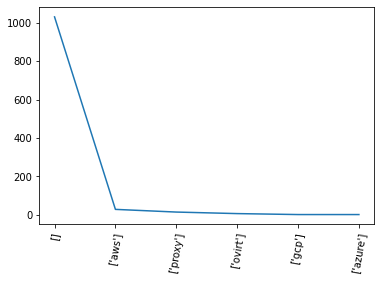

In [26]:
df["variant_type"].value_counts().plot()
plt.xticks(rotation=80)
plt.show()

In the above cell, we can see that the variant : aws and upgrade have been marked in the column variant_type.
This is how sippy looks up for some keywords that comprise of these variants and further categorize the tests accordingly.

#### Curated TRT Tests

In [27]:
## curated test substrings
curated_test = [
    "[Feature:SCC][Early] should not have pod creation failures during install",
    "infrastructure should work",
    "install should work",
    "Kubernetes APIs remain available",
    "OAuth APIs remain available",
    "OpenShift APIs remain available",
    "Pod Container Status should never report success for a pending container",
    "pods should never transition back to pending",
    "pods should successfully create sandboxes",
    "upgrade should work",
    "Cluster completes upgrade",
]

In [28]:
df["Curated TRT"] = details["original-name"].apply(
    lambda x: [m for m in curated_test if m in x]
)
df["Curated TRT"] = df["Curated TRT"].map(str)

In [29]:
df["Curated TRT"].head()

0    []
1    []
2    []
3    []
4    []
Name: Curated TRT, dtype: object

In [30]:
df["Curated TRT"].unique()

array(['[]',
       "['[Feature:SCC][Early] should not have pod creation failures during install']",
       "['pods should successfully create sandboxes']",
       "['Pod Container Status should never report success for a pending container']",
       "['pods should never transition back to pending']"], dtype=object)

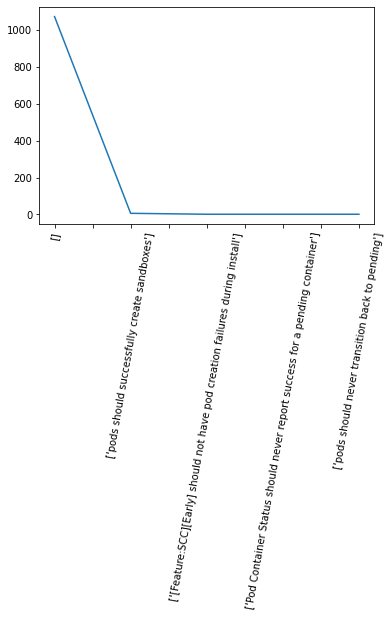

In [31]:
df["Curated TRT"].value_counts().plot()
plt.xticks(rotation=80)
plt.show()

In [32]:
## Custom Job Setup Containers
custom_job = [
    "e2e-aws-upgrade-ipi-install-install-stableinitial",
    "e2e-aws-upgrade-rollback-ipi-install-install-stableinitial",
    "e2e-aws-proxy-ipi-install-install",
    "e2e-aws-workers-rhel7-ipi-install-install",
    "e2e-azure-upgrade-ipi-conf-azure",
    "e2e-gcp-upgrade-ipi-install-install-stableinitial",
    "e2e-metal-ipi-baremetalds-devscripts-setup",
    "e2e-metal-ipi-ovn-ipv6-baremetalds-devscripts-setup",
    "e2e-metal-ipi-ovn-dualstack-baremetalds-devscripts-setup",
    "e2e-vsphere-ipi-install-vsphere",
    "e2e-vsphere-upi-upi-install-vsphere",
    "e2e-vsphere-upi-serial-upi-install-vsphere",
    "e2e-vsphere-serial-ipi-install-vsphere",
]

In [33]:
df["customJob"] = details["original-name"].apply(
    lambda x: [m for m in custom_job if m in x]
)
df["customJob"] = df["customJob"].map(str)
df.head()

,original-name,alert,linked_bugs,messages,short_texts,statuses,target,user_property,Type,Test Name,values,variant_type,Curated TRT,customJob
0,openshift-tests.[sig-imageregistry][Feature:Im...,NA,[],[0/2 runs passed: fail [k8s.io/kubernetes@v1.1...,"[0/2, , , , , 1/2, , , , , , , , , , , , , , ,...","[{'count': 1, 'value': 12}, {'count': 4, 'valu...",openshift-tests.[sig-imageregistry][Feature:Im...,NA,openshift-tests,[sig-imageregistry][Feature:ImageExtract] Imag...,"[12, 1, 1, 1, 1, 13, 1, 1, 1, 1, 1, 1, 1, 1, 1...",[],[],[]
1,openshift-tests.[sig-imageregistry][Feature:Im...,NA,[],[0/2 runs passed: fail [github.com/openshift/o...,"[0/2, , , , , , , , , , , , , , , , , , , , , ...","[{'count': 1, 'value': 12}, {'count': 48, 'val...",openshift-tests.[sig-imageregistry][Feature:Im...,NA,openshift-tests,[sig-imageregistry][Feature:ImageTriggers] Ann...,"[12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[],[],[]
2,operator.Run template e2e-aws - e2e-aws contai...,NA,[],[psq node/ip-10-0-80-253.ec2.internal containe...,"[F, , , F, , , , , , , , , , , , , , , , F, , ...","[{'count': 1, 'value': 12}, {'count': 2, 'valu...",operator.Run template e2e-aws - e2e-aws contai...,NA,operator,Run template e2e-aws - e2e-aws container test,"[12, 1, 1, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",['aws'],[],[]
3,release-openshift-origin-installer-e2e-aws-sha...,NA,[],"[, , , , , , ]","[, , , , , , ]","[{'count': 1, 'value': 12}, {'count': 2, 'valu...",release-openshift-origin-installer-e2e-aws-sha...,NA,release-openshift-origin-installer-e2e-aws-sha...,6.Overall,"[12, 1, 1, 12, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0...",['aws'],[],[]
4,openshift-tests.[sig-arch] Monitor cluster whi...,NA,[],[1/2 runs passed: 494 error level events were ...,"[1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, ...","[{'count': 60, 'value': 13}]",openshift-tests.[sig-arch] Monitor cluster whi...,NA,openshift-tests,[sig-arch] Monitor cluster while tests execute,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...",[],[],[]


In [34]:
# Valid Buzilla Components
ValidBugzillaComponents = [
    "apiserver-auth",
    "assisted-installer",
    "Bare Metal Hardware Provisioning",
    "Build",
    "Cloud Compute",
    "Cloud Credential Operator",
    "Cluster Loader",
    "Cluster Version Operator",
    "CNF Variant Validation",
    "Compliance Operator",
    "config-operator",
    "Console Kubevirt Plugin",
    "Console Metal3 Plugin",
    "Console Storage Plugin",
    "Containers",
    "crc",
    "Dev Console",
    "DNS",
    "Documentation",
    "Etcd",
    "Federation",
    "File Integrity Operator",
    "Fuse",
    "Hawkular",
    "ibm-roks-toolkit",
    "Image",
    "Image Registry",
    "Insights Operator",
    "Installer",
    "ISV Operators",
    "Jenkins",
    "kata-containers",
    "kube-apiserver",
    "kube-controller-manager",
    "kube-scheduler",
    "kube-storage-version-migrator",
    "Logging",
    "Machine Config Operator",
    "Management Console",
    "Metering Operator",
    "Migration Tooling",
    "Monitoring",
    "Multi-Arch",
    "Multi-cluster-management",
    "Networking",
    "Node",
    "Node Feature Discovery Operator",
    "Node Tuning Operator",
    "oauth-apiserver",
    "oauth-proxy",
    "oc",
    "OLM",
    "openshift-apiserver",
    "openshift-controller-manager",
    "Operator SDK",
    "Performance Addon Operator",
    "Reference Architecture",
    "Registry Console",
    "Release",
    "RHCOS",
    "RHMI Monitoring",
    "Routing",
    "Samples",
    "Security",
    "Service Broker",
    "Service Catalog",
    "service-ca",
    "Special Resources Operator",
    "Storage",
    "Templates",
    "Test Infrastructure",
    "Unknown",
    "Windows Containers",
]

In [35]:
df["Valid Bugzilla Components"] = details["original-name"].apply(
    lambda x: [m for m in ValidBugzillaComponents if m in x]
)
df["Valid Bugzilla Components"] = df["Valid Bugzilla Components"].map(str)

In [36]:
df

,original-name,alert,linked_bugs,messages,short_texts,statuses,target,user_property,Type,Test Name,values,variant_type,Curated TRT,customJob,Valid Bugzilla Components
0,openshift-tests.[sig-imageregistry][Feature:Im...,NA,[],[0/2 runs passed: fail [k8s.io/kubernetes@v1.1...,"[0/2, , , , , 1/2, , , , , , , , , , , , , , ,...","[{'count': 1, 'value': 12}, {'count': 4, 'valu...",openshift-tests.[sig-imageregistry][Feature:Im...,NA,openshift-tests,[sig-imageregistry][Feature:ImageExtract] Imag...,"[12, 1, 1, 1, 1, 13, 1, 1, 1, 1, 1, 1, 1, 1, 1...",[],[],[],['Image']
1,openshift-tests.[sig-imageregistry][Feature:Im...,NA,[],[0/2 runs passed: fail [github.com/openshift/o...,"[0/2, , , , , , , , , , , , , , , , , , , , , ...","[{'count': 1, 'value': 12}, {'count': 48, 'val...",openshift-tests.[sig-imageregistry][Feature:Im...,NA,openshift-tests,[sig-imageregistry][Feature:ImageTriggers] Ann...,"[12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[],[],[],['Image']
2,operator.Run template e2e-aws - e2e-aws contai...,NA,[],[psq node/ip-10-0-80-253.ec2.internal containe...,"[F, , , F, , , , , , , , , , , , , , , , F, , ...","[{'count': 1, 'value': 12}, {'count': 2, 'valu...",operator.Run template e2e-aws - e2e-aws contai...,NA,operator,Run template e2e-aws - e2e-aws container test,"[12, 1, 1, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",['aws'],[],[],[]
3,release-openshift-origin-installer-e2e-aws-sha...,NA,[],"[, , , , , , ]","[, , , , , , ]","[{'count': 1, 'value': 12}, {'count': 2, 'valu...",release-openshift-origin-installer-e2e-aws-sha...,NA,release-openshift-origin-installer-e2e-aws-sha...,6.Overall,"[12, 1, 1, 12, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0...",['aws'],[],[],[]
4,openshift-tests.[sig-arch] Monitor cluster whi...,NA,[],[1/2 runs passed: 494 error level events were ...,"[1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, 1/2, ...","[{'count': 60, 'value': 13}]",openshift-tests.[sig-arch] Monitor cluster whi...,NA,openshift-tests,[sig-arch] Monitor cluster while tests execute,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...",[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1076,operator.Find all of the input images from ocp...,NA,[],"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 60, 'value': 1}]",operator.Find all of the input images from ocp...,NA,operator,Find all of the input images from ocp/4.6:${co...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],[],[],['oc']
1077,"operator.Import the release payload ""latest"" f...",NA,[],"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 60, 'value': 1}]","operator.Import the release payload ""latest"" f...",NA,operator,"Import the release payload ""latest"" from an ex...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[],[],[],[]
1078,operator.Run template e2e-aws - e2e-aws contai...,NA,[],"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 60, 'value': 1}]",operator.Run template e2e-aws - e2e-aws contai...,NA,operator,Run template e2e-aws - e2e-aws container setup,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",['aws'],[],[],[]
1079,operator.Run template e2e-aws - e2e-aws contai...,NA,[],"[, , , , , , , , , , , , , , , , , , , , , , ,...","[, , , , , , , , , , , , , , , , , , , , , , ,...","[{'count': 60, 'value': 1}]",operator.Run template e2e-aws - e2e-aws contai...,NA,operator,Run template e2e-aws - e2e-aws container teardown,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",['aws'],[],[],[]


In [37]:
df["Valid Bugzilla Components"].unique()

array(["['Image']", '[]', "['Node']", "['oc']", "['kube-apiserver']",
       "['Image', 'oc']", "['config-operator']",
       "['kube-controller-manager']", "['kube-scheduler']",
       "['kube-storage-version-migrator']", "['openshift-apiserver']",
       "['openshift-controller-manager']", "['service-ca']",
       "['Node', 'oc']", "['Containers', 'Node', 'oc']", "['Security']",
       "['Node', 'Security']", "['Unknown']", "['Build']",
       "['Build', 'oc']", "['Build', 'Image']", "['Templates']",
       "['Build', 'Image', 'oc']", "['Networking']", "['DNS']",
       "['Networking', 'Node']", "['OLM']"], dtype=object)

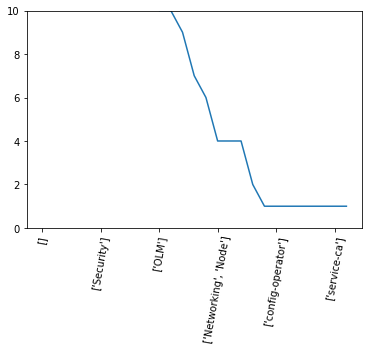

In [38]:
df["Valid Bugzilla Components"].value_counts().plot()
plt.xticks(rotation=80)
plt.ylim(0, 10)
plt.show()

In this notebook, we have seen a few categories like Curated Jobs, classifying the jobs based on Variants and Bugzilla Components that can be seen on Sippy Dashboard. We can also try out more dashboards to see better results. This notebook takes in account job: https://testgrid.k8s.io/redhat-openshift-ocp-release-4.6-informing/table?&show-stale-tests=&tab=release-openshift-origin-installer-e2e-aws-upgrade-rollback-4.5-to-4.6 case. But we can change this link in cell[10] and see various different dashboards and perform this analysis sippy uses.